# Classification
In this document, we will some of the most known algorithms and technqiues used in classification  
We will conduct a test on the MNIST dataset

In [25]:
# We fetch different datasets from the openml project
from sklearn.datasets import fetch_openml

# We get the mnist data
mnist = fetch_openml("mnist_784")

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:  
• A DESCR key describing the dataset  
• A data key containing an array with one row per instance and one column per feature  
• A target key containing an array with the labels  

In [71]:
# The description of the dataset
print(f"The description : {mnist['DESCR']}")

print(f"The data in the mnist set : {mnist["data"]}")

print(f"The features in the dataset : {mnist["feature_names"]}")

The description : **Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered 

In [72]:
# Let's now get the X and Y from the dataset 
X , y = mnist["data"], mnist["target"]
X = X.to_numpy()
print(type(X))

<class 'numpy.ndarray'>


In [73]:
print(f"The shape of X : {X.shape}")
print(f"The shape of y : {y.shape}")

The shape of X : (70000, 784)
The shape of y : (70000,)


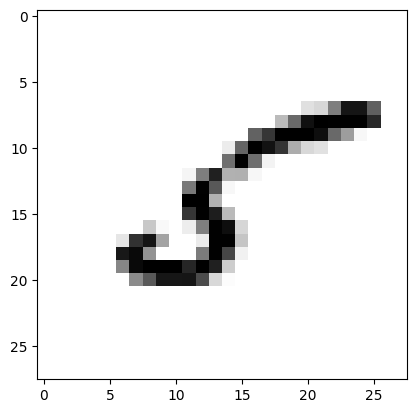

In [106]:
# We can go and show some digits using matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Assuming X is the dataset, such as the MNIST dataset
random_digit = X[11]
random_digit_image = random_digit.reshape(28, 28)  # Change it into a 28x28 image

# Display the digit using the correct binary colormap
plt.imshow(random_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()  # Show the plot


## Creating a test set
The MNIST dataset is already splitted into a training set ( the first 60000 ) and a test set ( the last 10000 )

In [75]:
X_train,X_test, y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will
be similar (you don’t want one fold to be missing some digits). Moreover, some learn‐
ing algorithms are sensitive to the order of the training instances, and they perform
poorly if they get many similar instances in a row. Shuffling the dataset ensures that
this won’t happen

In [76]:
import numpy as np

# Step 1: Create a shuffled index array of length 60000
shuffle_index = np.random.permutation(60000)

# Step 2: Shuffle the training data based on the shuffled index
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


## Training a binary classfier

Let's start by simplifying the problem , we will try and work on creating a model that can detect a 5 from a non 5

In [77]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [78]:
y_train_5 = (y_train == 5) # Gives  1 for a 5, and a 0 for a non 5
y_test_5 = (y_test == 5)

In [79]:
y_train_5

50067    False
46984    False
31821     True
4901     False
12115    False
         ...  
31316     True
29134    False
55846    False
31212    False
57297    False
Name: class, Length: 60000, dtype: bool

Now let’s pick a classifier and train it. A good place to start is with a Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐
sifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [81]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

In [92]:
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

The SGDClassifier relies on randomness during training (hence
the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.

After completing our training, we can test the model by predicting on our random_digit that we setted earlier

In [58]:
# The entry of the model should be a 2D array, don't forget about It
sgd_clf.predict([random_digit,X[4563],X[42]])

array([False, False, False])

It seems that it is giving correct answers for our training set, but let's test It and apply a performance measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance
measures available, so grab another coffee and get ready to learn many new concepts
and acronyms!

**Using Cross Validation**

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

print(skfolds)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    
    print(train_index)
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    # Train the cloned model on the new split
    clone_clf.fit(X_train_folds,y_train_folds)
    y_hat = clone_clf.predict(X_test_folds)
    n_correct = sum(y_hat == y_test_folds)
    
    print(n_correct/len(y_hat))

StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
[    0     1     2 ... 59995 59996 59997]
0.90125
[    1     2     6 ... 59997 59998 59999]
0.90905
[    0     3     4 ... 59993 59998 59999]
0.76325


Let's use now a Cross-val score to measure the performance

In [85]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.96385, 0.9603 , 0.9637 ])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

A much better way, would be to use the confusion matrix

A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix

In [87]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53524,  1055],
       [ 1188,  4233]])

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class.

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive pre‐
dictions; this is called the precision of the classifier

precision = TP / TP + FP

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifier

recall = TP / TP + FN

In [89]:
from sklearn.metrics import precision_score,recall_score

print(f"The precision is {precision_score(y_train_5,y_train_pred)}")
print(f"The recall is {recall_score(y_train_5,y_train_pred)}")

The precision is 0.8004916792738276
The recall is 0.780852241283896


It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1
 score is 
the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1
 score if both recall and precision are
high.

F1 = 2 × (precision × recall) /  (precision + recall)

In [90]:
from sklearn.metrics import f1_score

print(f"The F1 score is {f1_score(y_train_5,y_train_pred)}")

The F1 score is 0.7905500046689701


The F1
score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught)

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeo.


## Precision / Recall Tradeoff
If we see how does the SGDClassifier, It calculates a score based on a decision function and compare It to threshhold  
If it surpasses the threshold, It gives a positive, else It gives a negative  
Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:



In [107]:
y_scores = sgd_clf.decision_function([random_digit])

In [108]:
y_scores

array([7277.67094061])

In [110]:
threshold = 0

y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([ True])

But ,what happens when we augmente the threshold

In [111]:
threshold = 7300

y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([False])

The result is now false  
So how can you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of
predictions:


In [112]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

Now with these scores you can compute precision and recall for all possible thresh‐
olds using the precision_recall_curve() function

In [113]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [129]:
def plot_prc(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label="Precision")
    plt.plot(thresholds,recalls[:-1],'g-',label="Recall")
    plt.xlabel("Threshhold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    
    

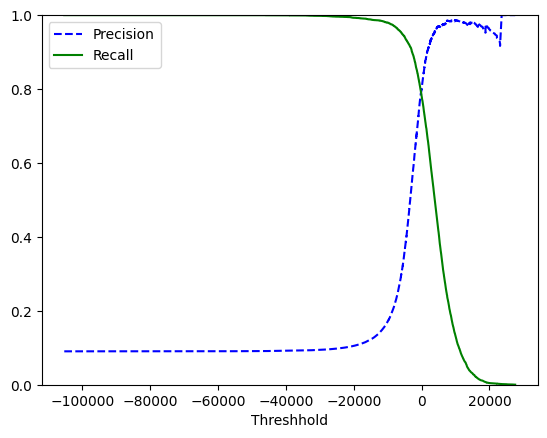

In [130]:
plot_prc(precisions,recalls,thresholds)

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. But of course the choice depends on your project.
So let’s suppose you decide to aim for 90% precision. You look up the first plot
(zooming in a bit) and find that you need to use a threshold of about 70,000. To make
predictions (on the training set for now), instead of calling the classifier’s predict()
method, you can just run this code:

In [121]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [131]:
recall_score(y_train_5,y_train_pred_90)

np.float64(0.0)

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate, 
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [132]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

In [135]:
def plot_roc(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.plot([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    

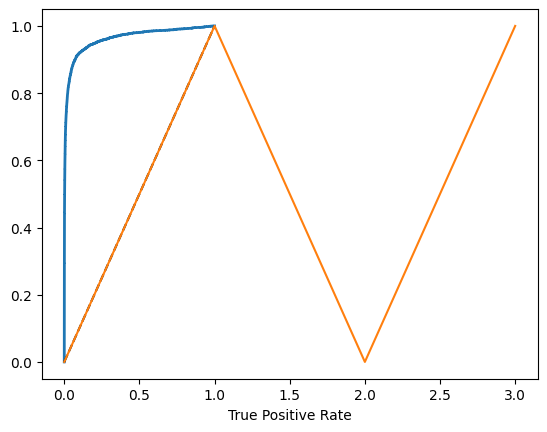

In [136]:
plot_roc(fpr,tpr)

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:


In [138]:
from sklearn.metrics import roc_auc_score

roc_score = roc_auc_score(y_train_5,y_scores)
roc_score

np.float64(0.9624673185948829)

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright corner).

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier. First, you need to get scores for each instance in the
training set. But due to the way it works (see Chapter 7), the RandomForestClassi
fier class does not have a decision_function() method. Instead it has a pre
dict_proba() method. Scikit-Learn classifiers generally have one or the other. The
predict_proba() method returns an array containing a row per instance and a col‐
umn per class, each containing the probability that the given instance belongs to the
given class (e.g., 70% chance that the image represents a 5)

In [139]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [141]:
# When printing the y_probas_forest, it is still a proba, but as we want score
# That's why we take the proba of the positive
print(y_probas_forest[:,1])

[0.01 0.   0.75 ... 0.   0.01 0.02]


In [142]:
y_forest_scores = y_probas_forest[:,1]

fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_forest_scores)

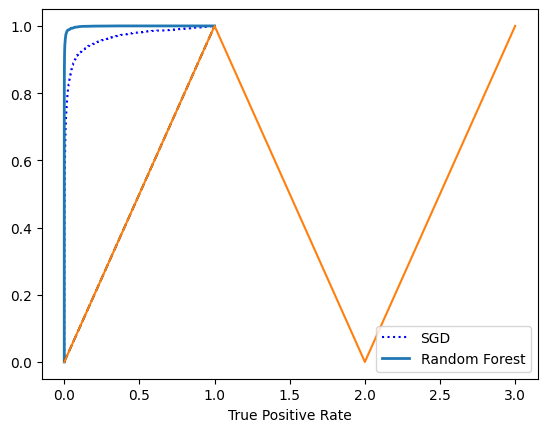

In [144]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="best")


As you can see in Figure 3-7, the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better

In [145]:
roc_auc_score(y_train_5,y_forest_scores)

np.float64(0.9984517026793941)

Try measuring the precision and recall scores: you should find 98.5% precision and
82.8% recall. Not too bad!
Hopefully you now know how to train binary classifiers, choose the appropriate met‐
ric for your task, evaluate your classifiers using cross-validation, select the precision/
recall tradeoff that fits your needs, and compare various models using ROC curves
and ROC AUC scores. Now let’s try to detect more than just the 5s.

## Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are vari‐
ous strategies that you can use to perform multiclass classification using multiple
binary classifiers.
For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy 
(also called one-versus-the-rest).
Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.
Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, OvA is preferred.
Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvA (exceppt for SVM classifiers for
which it uses OvO). Let’s try this with the SGDClassifier:

In [146]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(random_state=42)

It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. For exam‐
ple, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above
90%

In [147]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [148]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

KeyboardInterrupt: 

## Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one label per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary labels is called a multilabel classification system.

In [149]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clfs = KNeighborsClassifier()

print(y_multilabel)
knn_clfs.fit(X_train,y_multilabel)

[[False  True]
 [False  True]
 [False  True]
 ...
 [False  True]
 [False False]
 [False False]]


KNeighborsClassifier()

In [150]:
knn_clfs.predict([random_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F1
 score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F1
score across all
labels

In [151]:
y_train_knn_pred = cross_val_predict(knn_clfs,X_train,y_train,cv=3)

np.float64(0.9685443824203224)

In [152]:
f1_score(y_train,y_train_knn_pred,average="macro")

np.float64(0.9684234726165573)

In [153]:
f1_score(y_train,y_train_knn_pred,average="weighted") # If some images were more important than others, so we add some weights to the entries

np.float64(0.9685443824203224)

## Multioutput Classification

he last type of classification task we are going to discuss here is called multioutputmulticlass classification (or simply multioutput classification). It is simply a generaliza‐
tion of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values